# An Intro to H2O via R
### Author: Brad Sliz (d7oz)

_-Hold up, is that R in a notebook?!?_
<img src="https://www.r-project.org/Rlogo.png" />
<img src="https://jupyter.org/assets/main-logo.svg" />
_-Yes, yes that is._

DAPS has made it extremely easy to set up Jupyter notebooks for R.  If you already have Anaconda set up, just run the following two commands from an R session on the PHD edge node:

`source("/san-data/training-tools/IRkernel/setup.R")`

`IRkernel::installspec()`

Then when you open a notebook, you will see R as an option for new notebook styles.  For more details about setup, check out the State Farm [R user community page](https://sfwikis.opr.statefarm.org/sites/systems/Wiki%20Pages/R%20User%20Community%20Page.aspx#Setting_x0020_up_x0020_IRKernel_x0020_in_x0020_Jupyter_0_0_3_5_0_0_0_0_0_0_0_0_0_0_0_0 for more details).

<img src="http://h2o.ai/assets/images/h2o-home.png" />
This notebook steps through how to 
- Start H2O from R, 
- Pass data to H2O from R, 
- Run a model in H2O, 
- Interact with H2O results, 
- Run a distributed H2O job, 
- Read in data from HDFS.
Getting started
===

In [1]:
library(h2o)

Loading required package: statmod

----------------------------------------------------------------------

Your next step is to start H2O and get a connection object (named
'localH2O', for example):
    > localH2O = h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------



A call to `h2o.init()` starts an h2o virtual machine with  a specified number of cores.  The h2o vm can be accessed via an assigned R object. By specifying `nthreads = -1`, all available cores are allocated to the VM.

In [2]:
my_h2o <- h2o.init(nthreads = 8)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpUL4ra5/h2o_d7oz_started_from_r.out
    /tmp/RtmpUL4ra5/h2o_d7oz_started_from_r.err


..Successfully connected to http://127.0.0.1:54321/ 

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 seconds 999 milliseconds 
    H2O cluster version:        3.0.1.7 
    H2O cluster name:           H2O_started_from_R_d7oz_aht312 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   26.60 GB 
    H2O cluster total cores:    96 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 



Info on your H2O cluster is returned on startup.  At any time you can re-check this info with `h2o.clusterInfo()`

In [3]:
h2o.clusterInfo(my_h2o)

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 213 milliseconds 
    H2O cluster version:        3.0.1.7 
    H2O cluster name:           H2O_started_from_R_d7oz_aht312 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   26.60 GB 
    H2O cluster total cores:    96 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 


Pass data to H2O
===

In [4]:
head(iris)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


In [5]:
iris_h2o <- as.h2o(iris)
head(iris_h2o)

  |======================================================================| 100%


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


Run a model in H2O
===

In [6]:
vars <- colnames(iris_h2o)

rf_h2o <- h2o.randomForest(y = 'Species'
                           ,x = vars[-5]
                           ,training_frame = iris_h2o
                           ,seed = 71)

rf_h2o

  |======================================================================| 100%


Model Details:

H2OMultinomialModel: drf
Model ID:  DRF_model_R_1442599896107_5 
Model Summary:
  number_of_trees model_size_in_bytes min_depth max_depth mean_depth min_leaves
1             150               20566         1         8    3.79333          2
  max_leaves mean_leaves
1         15     6.28000


H2OMultinomialMetrics: drf
** Reported on training data. **
Description: Metrics reported on Out-Of-Bag training samples

Training Set Metrics: 
Metrics reported on Out-Of-Bag training samples 

Extract training frame with `h2o.getFrame("file10c4f7e01a585_csv_1.hex_2")`
MSE: (Extract with `h2o.mse`) 0.04025251
R^2: (Extract with `h2o.r2`) 0.9396212
Logloss: (Extract with `h2o.logloss`) 0.3386334
Confusion Matrix: Extract with `h2o.confusionMatrix(<model>,train=TRUE)`)
           setosa versicolor virginica      Error    Rate
setosa         50          0         0 0.00000000  0 / 50
versicolor      0         47         3 0.06000000  3 / 50
virginica       0          4        46 0.0800

Interact with H2O results
===
Even though the model was executed in the H2O vm, all of the results are still available in the R object assigned to it.  This is an S4 object, so we can access the model info via its' slots.  Generally slots are accessed via the `@` operator, and can be looked up via the function `slotNames`.  For a nice primer on S4 objects, check out [this chapter](http://adv-r.had.co.nz/S4.html) in Hadley Wickham's Advanced R book.

In [7]:
slotNames(rf_h2o)

[1] "conn"          "model_id"      "algorithm"     "parameters"   
[5] "allparameters" "model"         "finalizers"

In [8]:
rf_h2o@model

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[1]]) result is length 0


$cross_validation_models
NULL

$cross_validation_predictions
NULL

$model_summary
Model Summary:
  number_of_trees model_size_in_bytes min_depth max_depth mean_depth min_leaves
1             150               20566         1         8    3.79333          2
  max_leaves mean_leaves
1         15     6.28000

$scoring_history
Scoring History:
            timestamp   duration number_of_trees training_MSE training_logloss
1 2015-09-18 13:11:40  0.191 sec               1      0.04787          1.48448
2 2015-09-18 13:11:40  0.245 sec               2      0.11515          3.33395
3 2015-09-18 13:11:40  0.293 sec               3      0.07504          1.92775
4 2015-09-18 13:11:40  0.339 sec               4      0.05835          1.41421
5 2015-09-18 13:11:40  0.378 sec               5      0.05687          1.34931
  training_classification_error
1                       0.06383
2                       0.12941
3                       0.09821
4                       0.07752
5                       

In [9]:
rf_varimp_h2o <- rf_h2o@model$variable_importance

rf_varimp_h2o

,variable,relative_importance,scaled_importance,percentage
1,Petal.Width,2374.334,1,0.5426468
2,Petal.Length,1583.687,0.6670028,0.3619469
3,Sepal.Length,318.4704,0.1341304,0.07278544
4,Sepal.Width,98.97685,0.04168616,0.02262086


We can do any of the typical R processes with these results (because they are captured in an R object).  For example, we can plot the variable importance.

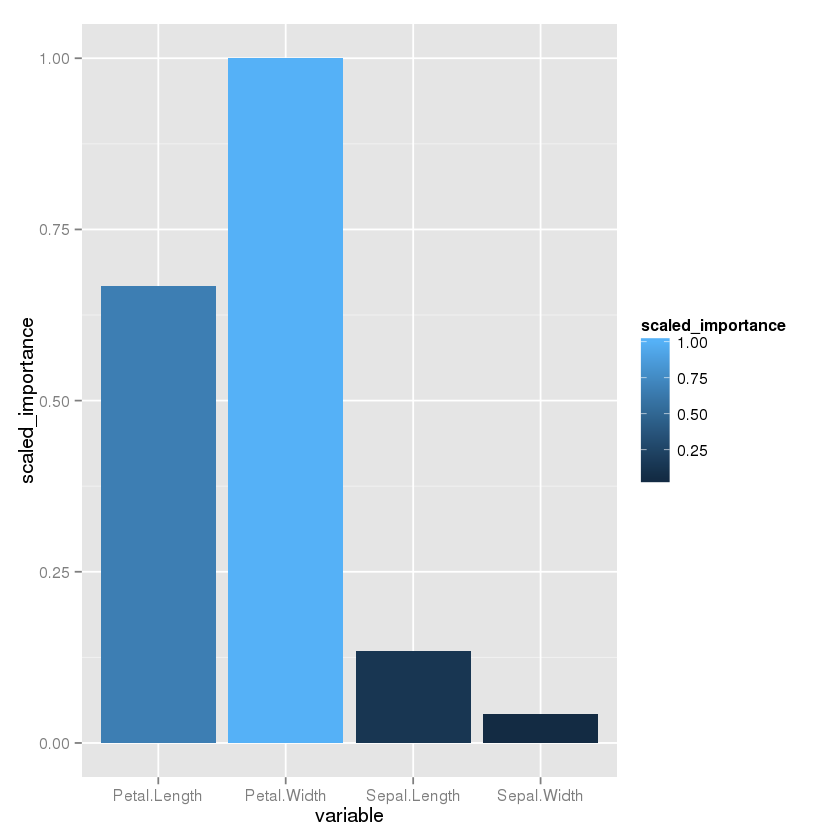

In [10]:
library(ggplot2)
     
ggplot(rf_varimp_h2o, aes(x = variable
                          ,y = scaled_importance
                          ,fill = scaled_importance) ) +
geom_bar(stat = 'identity')


In [11]:
h2o.shutdown(my_h2o
             ,prompt = F)

[1] TRUE

Distributed H2O
===
Say you want to run a _distributed_ job because your data lives in HDFS, or you just need more computing resources.  This can be done, but first requires a few steps from the command line. For details on this method, check [here](https://wss.opr.statefarm.org/sites/WSS003733/wiki/Pages/0xdata%20h2o.aspx).


Alternatively, I have created a helper script that does this for you. 

First, consider the memory requirements for your job, then appropriately tweak the parameters in the helper script to specify the number of nodes and size of each node.  Once you have these parameters set, save the script so it can be `source()`'d.

Thanks to Hades' three-headed hellhound Kerberos, you next need to `kdestroy; kinit` on the edge node.

In [12]:
source('h2o_make_cluster.R')

Warning message:
In file.remove("h2o_launch.log", showWarnings = F): cannot remove file 'h2o_launch.log', reason 'No such file or directory'Warning message:
In file.remove("h2o_launch.log", showWarnings = F): cannot remove file 'FALSE', reason 'No such file or directory'Warning message:
In readLines("h2o_launch.log"): incomplete final line found on 'h2o_launch.log'Warning message:
In readLines("h2o_launch.log"): incomplete final line found on 'h2o_launch.log'Warning message:
In file.remove("h2o_launch.log", showWarnings = F): cannot remove file 'FALSE', reason 'No such file or directory'

Successfully connected to http://10.96.242.234:54321/ 

R is connected to the H2O cluster: 
    H2O cluster uptime:         10 seconds 449 milliseconds 
    H2O cluster version:        3.0.1.7 
    H2O cluster name:           H2O_51003 
    H2O cluster total nodes:    8 
    H2O cluster total memory:   30.67 GB 
    H2O cluster total cores:    320 
    H2O cluster allowed cores:  320 
    H2O cluster healthy:        TRUE 



The helper script gives us an R object `my_h2o`, as before.  This time, it points at an h2o vm distributed to the specified specs across the cluster.
Read data from HDFS
===
(Note that the cell below will only run if you have access to the secanlty HDFS folder.  Substitute in your own HDFS file path)

In [13]:
h2o_data <- h2o.importFolder(my_h2o
                             ,path = 'hdfs://10.96.242.156/data/discovery/secanlty/derived/firewall_with_action/part-m-00001'
                             ,header = F )

  |======================================================================| 100%


By reading data in this fashion, we bypass the R "bottleneck" and read directly into the distributed H2O VM.

In [14]:
head(h2o_data)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13
1,2014-09-09T12:49:06.000Z,fw74cspec,denied,udp,10.96.3.201,53,192.168.101.100,62625,dn74int00.statefarm.org.,NA,NA,dns,1
2,2014-09-09T13:20:37.000Z,fw74cspec,denied,udp,10.96.3.201,53,192.168.101.100,60362,dn74int00.statefarm.org.,NA,NA,dns,1
3,2014-09-02T18:36:48.000Z,fw74cspec,denied,udp,10.96.3.201,53,192.168.101.100,59533,dn74int00.statefarm.org.,NA,NA,dns,1
4,2014-09-09T13:20:37.000Z,fw74cspec,denied,udp,10.96.3.201,53,192.168.101.100,55512,dn74int00.statefarm.org.,NA,NA,dns,1
5,2014-09-09T12:49:07.000Z,fw74cspec,denied,udp,10.96.3.201,53,192.168.101.100,62625,dn74int00.statefarm.org.,NA,NA,dns,1
6,2014-09-02T17:56:40.000Z,fw74cspec,denied,udp,10.96.3.201,53,192.168.101.100,64504,dn74int00.statefarm.org.,NA,NA,dns,1


In [15]:
col_names <- c('tmStamp'
               ,'firewall'
               ,'action'
               ,'protocol'
               ,'sourceIP'
               ,'sourcePort'
               ,'destIP'
               ,'destPort'
               ,'hostName'
               ,'city'
               ,'country'
               ,'compType'
               ,'tenDot')

colnames(h2o_data) <- col_names 

head(h2o_data)

,tmStamp,firewall,action,protocol,sourceIP,sourcePort,destIP,destPort,hostName,city,country,compType,tenDot
1,2014-09-09T12:49:06.000Z,fw74cspec,denied,udp,10.96.3.201,53,192.168.101.100,62625,dn74int00.statefarm.org.,NA,NA,dns,1
2,2014-09-09T13:20:37.000Z,fw74cspec,denied,udp,10.96.3.201,53,192.168.101.100,60362,dn74int00.statefarm.org.,NA,NA,dns,1
3,2014-09-02T18:36:48.000Z,fw74cspec,denied,udp,10.96.3.201,53,192.168.101.100,59533,dn74int00.statefarm.org.,NA,NA,dns,1
4,2014-09-09T13:20:37.000Z,fw74cspec,denied,udp,10.96.3.201,53,192.168.101.100,55512,dn74int00.statefarm.org.,NA,NA,dns,1
5,2014-09-09T12:49:07.000Z,fw74cspec,denied,udp,10.96.3.201,53,192.168.101.100,62625,dn74int00.statefarm.org.,NA,NA,dns,1
6,2014-09-02T17:56:40.000Z,fw74cspec,denied,udp,10.96.3.201,53,192.168.101.100,64504,dn74int00.statefarm.org.,NA,NA,dns,1


In [16]:
h2o.shutdown(my_h2o
             ,prompt = F)